## 1. 数据预处理

### 1.1 数据加载

In [1]:
import pandas as pd

# 选取 gene_expression, DNA methylation(450k), miRNA expression 数据
gene_expression_raw_data = pd.read_csv('data/gene_expression/batch_effects_normalized_mRNA_data', sep='\t', index_col=0, nrows=5000)
dna_methylation_450k_raw_data = pd.read_csv('data/DNA_methylation/DNA_methylation_450k', sep='\t', index_col=0, nrows=5000)
miRNA_expression_raw_data = pd.read_csv('data/miRNA_expression/batch_effects_normalized_miRNA_data', sep='\t', index_col=0, nrows=1000)

In [2]:
# 打印原始数据形状
gene_expression_raw_data.shape, dna_methylation_450k_raw_data.shape, miRNA_expression_raw_data.shape

((5000, 11069), (5000, 9664), (743, 10824))

### 1.2 样本匹配

In [3]:
# 获取每个数据集的列名（样本 ID）
gene_expression_samples = set(gene_expression_raw_data.columns)
dna_methylation_samples = set(dna_methylation_450k_raw_data.columns)
miRNA_expression_samples = set(miRNA_expression_raw_data.columns)

# 找到所有数据集中共有的样本 ID
common_samples = gene_expression_samples & dna_methylation_samples & miRNA_expression_samples

common_samples = list(common_samples)

# 使用共有的样本 ID 来过滤每个数据集
gene_expression_data = gene_expression_raw_data[common_samples]
dna_methylation_data = dna_methylation_450k_raw_data[common_samples]
miRNA_expression_data = miRNA_expression_raw_data[common_samples]


In [4]:
# 查看过滤后的数据集形状
gene_expression_data.shape, dna_methylation_data.shape, miRNA_expression_data.shape

((5000, 8959), (5000, 8959), (743, 8959))

### 1.3 数据清洗

In [5]:
# 定义清理函数
def clean_data(data):
    data = data.dropna(axis=1, thresh=0.7*data.shape[0])
    data = data.apply(lambda row: row.fillna(row.mean()), axis=1)
    data = data.fillna(0)
    return data

# 清理每种数据
gene_expression_data = clean_data(gene_expression_data)
dna_methylation_data = clean_data(dna_methylation_data)
miRNA_expression_data = clean_data(miRNA_expression_data)

In [6]:
# 检查是否包含NaN值
print("Gene Expression Data contains NaN:", gene_expression_data.isnull().values.any())
print("DNA Methylation 450K Data contains NaN:", dna_methylation_data.isnull().values.any())
print("miRNA Expression Data contains NaN:", miRNA_expression_data.isnull().values.any())

Gene Expression Data contains NaN: False
DNA Methylation 450K Data contains NaN: False
miRNA Expression Data contains NaN: False


### 1.4 数据标准化

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

gene_expression_data = pd.DataFrame(scaler.fit_transform(gene_expression_data), 
                                           index=gene_expression_data.index, columns=gene_expression_data.columns)
dna_methylation_data = pd.DataFrame(scaler.fit_transform(dna_methylation_data), 
                                       index=dna_methylation_data.index, columns=dna_methylation_data.columns)
miRNA_expression_data = pd.DataFrame(scaler.fit_transform(miRNA_expression_data), 
                                              index=miRNA_expression_data.index, columns=miRNA_expression_data.columns)


In [8]:
# 查看数据集形状
gene_expression_data.shape, dna_methylation_data.shape, miRNA_expression_data.shape

((5000, 8959), (5000, 8959), (743, 8959))

In [9]:
# # 转置便于后期处理 (列表示样本，行表示特征)
# gene_expression_data = gene_expression_data.T
# dna_methylation_data = dna_methylation_data.T
# miRNA_expression_data = miRNA_expression_data.T

In [10]:
# 查看数据集形状
gene_expression_data.shape, dna_methylation_data.shape, miRNA_expression_data.shape

((5000, 8959), (5000, 8959), (743, 8959))

## 2. 数据整合


### 2.1 数据降维

In [11]:
from sklearn.decomposition import PCA

# 使用 PCA 将每个数据集降维到 100 维
pca = PCA(n_components=100)
gene_expression_pca = pca.fit_transform(gene_expression_data.T)
dna_methylation_pca = pca.fit_transform(dna_methylation_data.T)
miRNA_expression_pca = pca.fit_transform(miRNA_expression_data.T)

In [12]:
import numpy as np

# 拼接特征
combined_data = np.concatenate((gene_expression_pca, dna_methylation_pca, miRNA_expression_pca), axis=1)


In [13]:
# 查看拼接后的数据集维度, 检查是否包含NaN值
combined_data.shape

(8959, 300)

## 3. 聚类分析


In [14]:
from sklearn.cluster import KMeans

# 使用 K-means 聚类
kmeans = KMeans(n_clusters=4)  # 假设我们想要分成3个簇
kmeans.fit(combined_data)
labels = kmeans.labels_


/home/ldz/Documents/anaconda3/envs/cluster/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### 3.1 评估

/home/ldz/Documents/anaconda3/envs/cluster/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ldz/Documents/anaconda3/envs/cluster/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ldz/Documents/anaconda3/envs/cluster/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ldz/Documents/anaconda3/envs/cluster/lib/python3.8/site-packages/sklearn/cluster/_kme

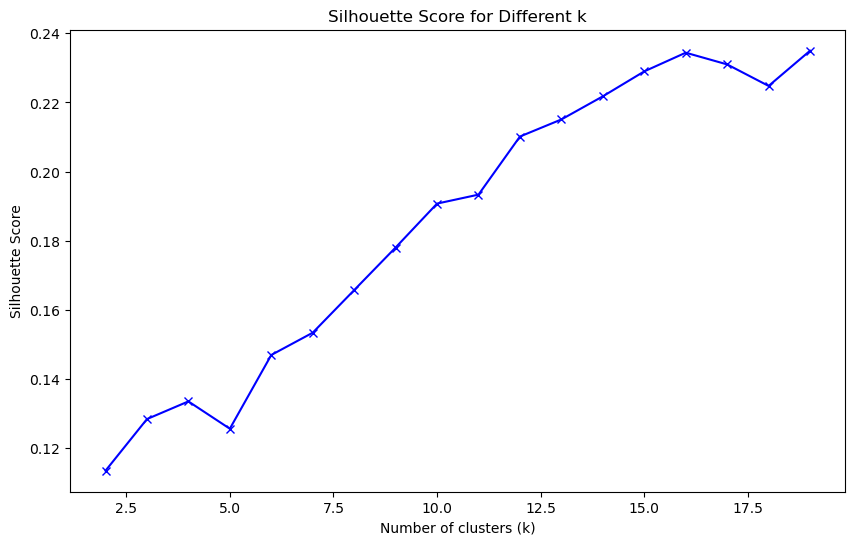

Best number of clusters: 19


/home/ldz/Documents/anaconda3/envs/cluster/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


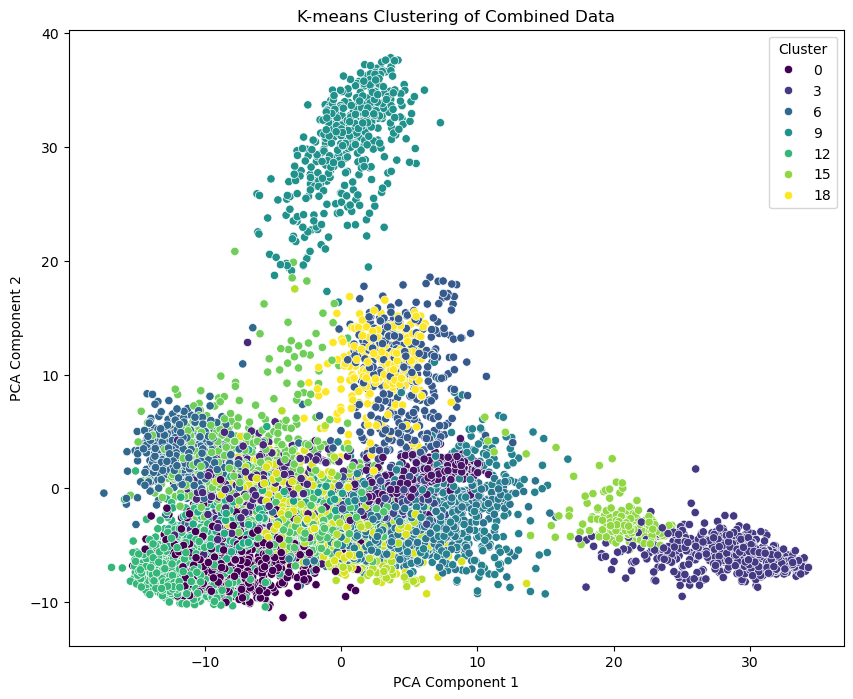

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns

# 拼接降维后的数据集
combined_data = np.concatenate((gene_expression_pca, dna_methylation_pca, miRNA_expression_pca), axis=1)

# 寻找最优的簇数量
silhouette_scores = []
K = range(2, 20)  # 我们尝试从2到10个簇
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(combined_data)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(combined_data, labels)
    silhouette_scores.append(silhouette_avg)

# 可视化不同簇数量下的轮廓系数
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.show()

# 选择最优簇数量并进行最终聚类
best_k = K[np.argmax(silhouette_scores)]
print(f'Best number of clusters: {best_k}')

kmeans = KMeans(n_clusters=best_k)
kmeans.fit(combined_data)
labels = kmeans.labels_

# 可视化聚类结果
plt.figure(figsize=(10, 8))
sns.scatterplot(x=combined_data[:, 0], y=combined_data[:, 1], hue=labels, palette='viridis')
plt.title('K-means Clustering of Combined Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

## 4. 结果分析和可视化

### 4.1 聚类结果可视化

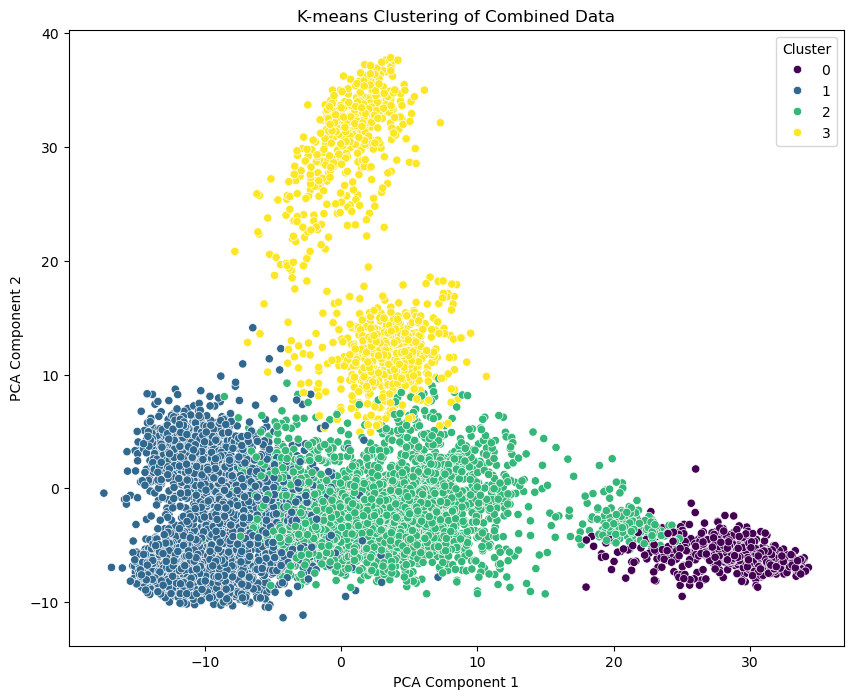

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 可视化聚类结果
plt.figure(figsize=(10, 8))
sns.scatterplot(x=combined_data[:, 0], y=combined_data[:, 1], hue=labels, palette='viridis')
plt.title('K-means Clustering of Combined Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()